## Машинное обучение в бизнесе
### Урок 7. Интерпретация прогнозов модели (SHAP): объясняем поведение модели на отдельных наблюдениях

Практическое задание:
- взять любой набор данных для бинарной классификации (можно скачать один из модельных с https://archive.ics.uci.edu/ml/datasets.php)
- сделать обзорный анализ выбранного датасета
- сделать feature engineering
- обучить любой классификатор (какой вам нравится)
- разобраться с SHAP и построить важности признаков для:
    - всего тестового набора данных (summary_plot - дать интерпретацию)
    - для топ 10%
- для отдельных наблюдений вывести force_plot и попытаться проинтерпретировать результат


---

In [46]:
import pandas as pd
import numpy as np
import calendar
from sklearn import preprocessing
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn import metrics
import shap

In [2]:
# https://archive.ics.uci.edu/dataset/222/bank+marketing
dataset = pd.read_csv('./bank.csv', delimiter=';')
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,unemployed,married,primary,no,1787,no,no,cellular,19,oct,79,1,-1,0,unknown,no
1,33,services,married,secondary,no,4789,yes,yes,cellular,11,may,220,1,339,4,failure,no
2,35,management,single,tertiary,no,1350,yes,no,cellular,16,apr,185,1,330,1,failure,no
3,30,management,married,tertiary,no,1476,yes,yes,unknown,3,jun,199,4,-1,0,unknown,no
4,59,blue-collar,married,secondary,no,0,yes,no,unknown,5,may,226,1,-1,0,unknown,no


In [36]:
TARGET = 'y'

In [3]:
dataset.describe()

,age,balance,day,duration,campaign,pdays,previous
count,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000,4521.000000
mean,41.170095,1422.657819,15.915284,263.961292,2.793630,39.766645,0.542579
std,10.576211,3009.638142,8.247667,259.856633,3.109807,100.121124,1.693562
min,19.000000,-3313.000000,1.000000,4.000000,1.000000,-1.000000,0.000000
25%,33.000000,69.000000,9.000000,104.000000,1.000000,-1.000000,0.000000
50%,39.000000,444.000000,16.000000,185.000000,2.000000,-1.000000,0.000000
75%,49.000000,1480.000000,21.000000,329.000000,3.000000,-1.000000,0.000000
max,87.000000,71188.000000,31.000000,3025.000000,50.000000,871.000000,25.000000


In [4]:
dataset['y'] = dataset['y'].map({'no':0, 'yes': 1})
dataset['y'] = dataset['y'].astype(int)

In [5]:
categorical_columns = [col for col in dataset.columns if dataset[col].dtype=="O"]
categorical_columns

['job',
 'marital',
 'education',
 'default',
 'housing',
 'loan',
 'contact',
 'month',
 'poutcome']

In [6]:
# Заменим все категориальные признаки
for c_ in categorical_columns:
    print(c_, dataset[c_].unique())

job ['unemployed' 'services' 'management' 'blue-collar' 'self-employed'
 'technician' 'entrepreneur' 'admin.' 'student' 'housemaid' 'retired'
 'unknown']
marital ['married' 'single' 'divorced']
education ['primary' 'secondary' 'tertiary' 'unknown']
default ['no' 'yes']
housing ['no' 'yes']
loan ['no' 'yes']
contact ['cellular' 'unknown' 'telephone']
month ['oct' 'may' 'apr' 'jun' 'feb' 'aug' 'jan' 'jul' 'nov' 'sep' 'mar' 'dec']
poutcome ['unknown' 'failure' 'other' 'success']


In [7]:
no_yes_map = {'no': 0, 'yes': 1}
for _ in ['default','housing', 'loan']:
    dataset[_] = dataset[_].map(no_yes_map)

In [8]:
month_map = {month.lower(): index for index, month in enumerate(calendar.month_abbr) if month}
dataset['month'] = dataset['month'].map(month_map)

In [9]:
jobs_map = {
    'unemployed': 0,
    'services': 1,
    'management': 1,
    'blue-collar': 1,
    'self-employed': 1,
    'technician': 1,
    'entrepreneur': 1,
    'admin.': 1,
    'student': 0,
    'housemaid': 0,
    'retired': 0,
    'unknown': 0
}

In [10]:
dataset['poutcome'] = dataset['poutcome'].map({'unknown':0,'failure': -1, 'other': 0, 'success': 1})
dataset['contact'] = dataset['contact'].map({'unknown':0, 'cellular': 1, 'telephone': 2})
dataset['education'] = dataset['education'].map({'unknown':0, 'primary': 1, 'secondary': 2, 'tertiary': 3})
dataset['marital'] = dataset['marital'].map({'unknown':0, 'married': 1, 'single': 0, 'divorced': 0})
dataset['job'] = dataset['job'].map(jobs_map)

In [11]:
dataset.head()

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,30,0,1,1,0,1787,0,0,1,19,10,79,1,-1,0,0,0
1,33,1,1,2,0,4789,1,1,1,11,5,220,1,339,4,-1,0
2,35,1,0,3,0,1350,1,0,1,16,4,185,1,330,1,-1,0
3,30,1,1,3,0,1476,1,1,0,3,6,199,4,-1,0,0,0
4,59,1,1,2,0,0,1,0,0,5,5,226,1,-1,0,0,0


In [12]:
for c_ in categorical_columns:
    dataset[c_] = dataset[c_].astype(int)

<AxesSubplot:>

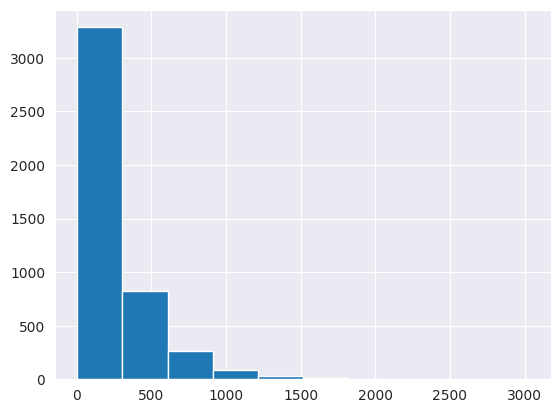

In [14]:
dataset['duration'].hist()

In [17]:
scaler = preprocessing.MinMaxScaler()
dataset[['balance','duration']] = scaler.fit_transform(dataset[['balance','duration']])

,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
age,1.000000,-0.277546,0.275139,-0.199345,-0.017885,0.083820,-0.193888,-0.011250,0.110989,-0.017853,0.073764,-0.002367,-0.005148,-0.008894,-0.003511,0.011486,0.045092
job,-0.277546,1.000000,-0.011810,0.170486,0.004854,-0.054641,0.221050,0.055545,-0.106241,0.007303,-0.002555,-0.024998,0.034968,0.017113,-0.006502,-0.018640,-0.079628
marital,0.275139,-0.011810,1.000000,-0.126771,-0.039031,0.017158,0.038432,0.032272,-0.014848,-0.001438,0.048739,-0.036436,0.022000,-0.016537,-0.017640,0.009251,-0.064643
education,-0.199345,0.170486,-0.126771,1.000000,-0.008835,0.035731,-0.031251,0.016102,0.078797,0.013508,0.078297,-0.003246,0.019268,0.006886,0.027320,-0.019762,0.050265
default,-0.017885,0.004854,-0.039031,-0.008835,1.000000,-0.070886,0.006881,0.063994,-0.021082,-0.013261,0.008917,-0.011615,-0.012348,-0.026317,-0.026656,0.024136,0.001303
balance,0.083820,-0.054641,0.017158,0.035731,-0.070886,1.000000,-0.050227,-0.071349,0.030763,-0.008677,0.099872,-0.015950,-0.009976,0.009437,0.026196,-0.008305,0.017905
housing,-0.193888,0.221050,0.038432,-0.031251,0.006881,-0.050227,1.000000,0.018451,-0.210574,-0.031291,-0.170922,0.015740,-0.003574,0.116893,0.038621,-0.121872,-0.104683
loan,-0.011250,0.055545,0.032272,0.016102,0.063994,-0.071349,0.018451,1.000000,0.002610,-0.004879,0.039226,-0.004997,0.017120,-0.031086,-0.022115,-0.013311,-0.070517
contact,0.110989,-0.106241,-0.014848,0.078797,-0.021082,0.030763,-0.210574,0.002610,1.000000,0.063496,0.165790,-0.005027,0.007929,0.210690,0.173410,-0.116539,0.125882
day,-0.017853,0.007303,-0.001438,0.013508,-0.013261,-0.008677,-0.031291,-0.004879,0.063496,1.000000,0.080436,-0.024629,0.160706,-0.094352,-0.059114,0.042493,-0.011244


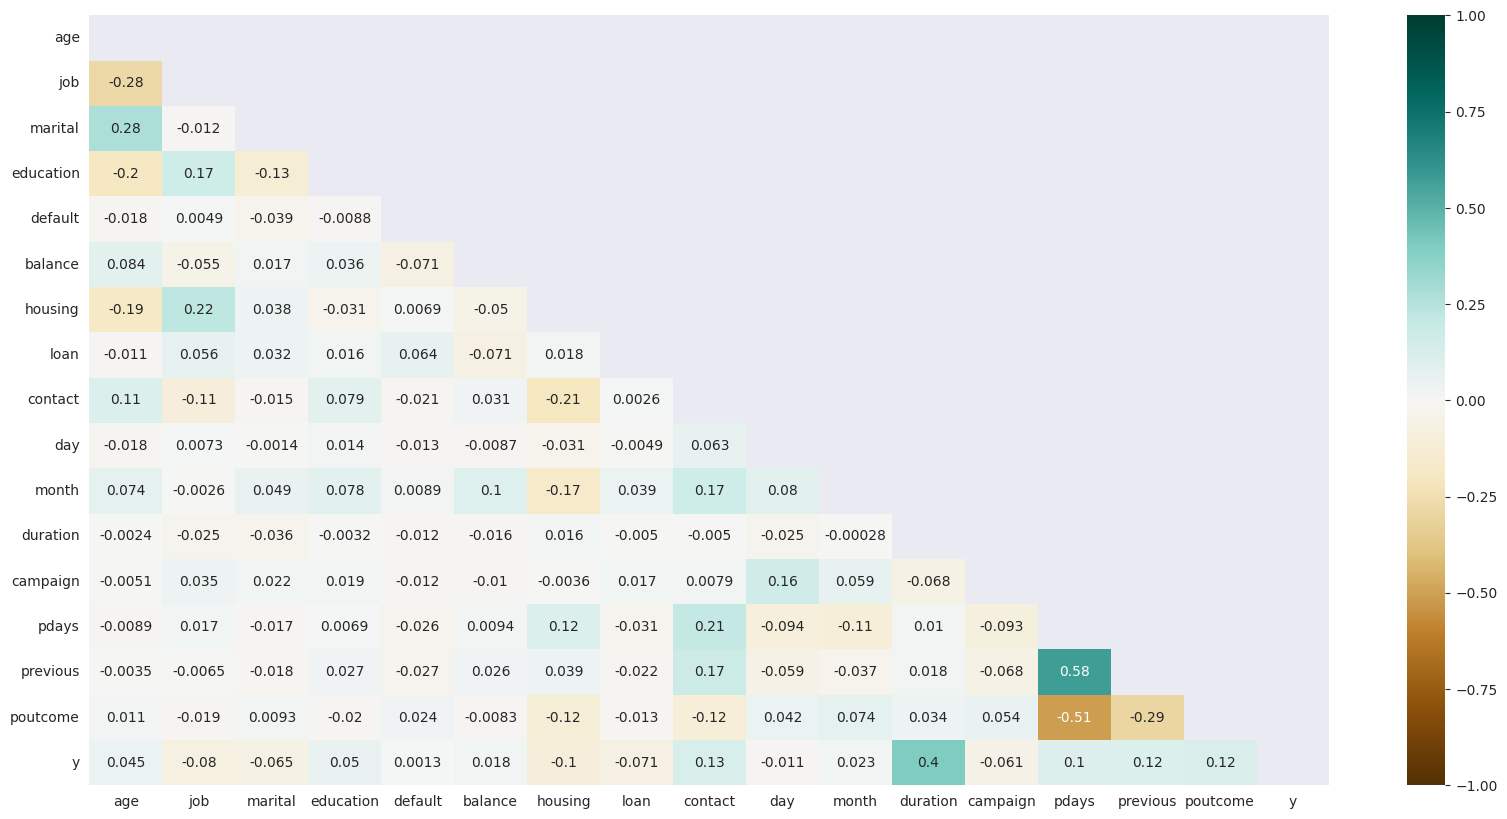

In [19]:
plt.figure(figsize=(20,10))
c= dataset.corr()
cor_matrix_mask = np.triu(np.ones_like(c, dtype=bool))
sns.heatmap(c,cmap="BrBG",annot=True, vmin=-1, vmax=1, mask=cor_matrix_mask)
c

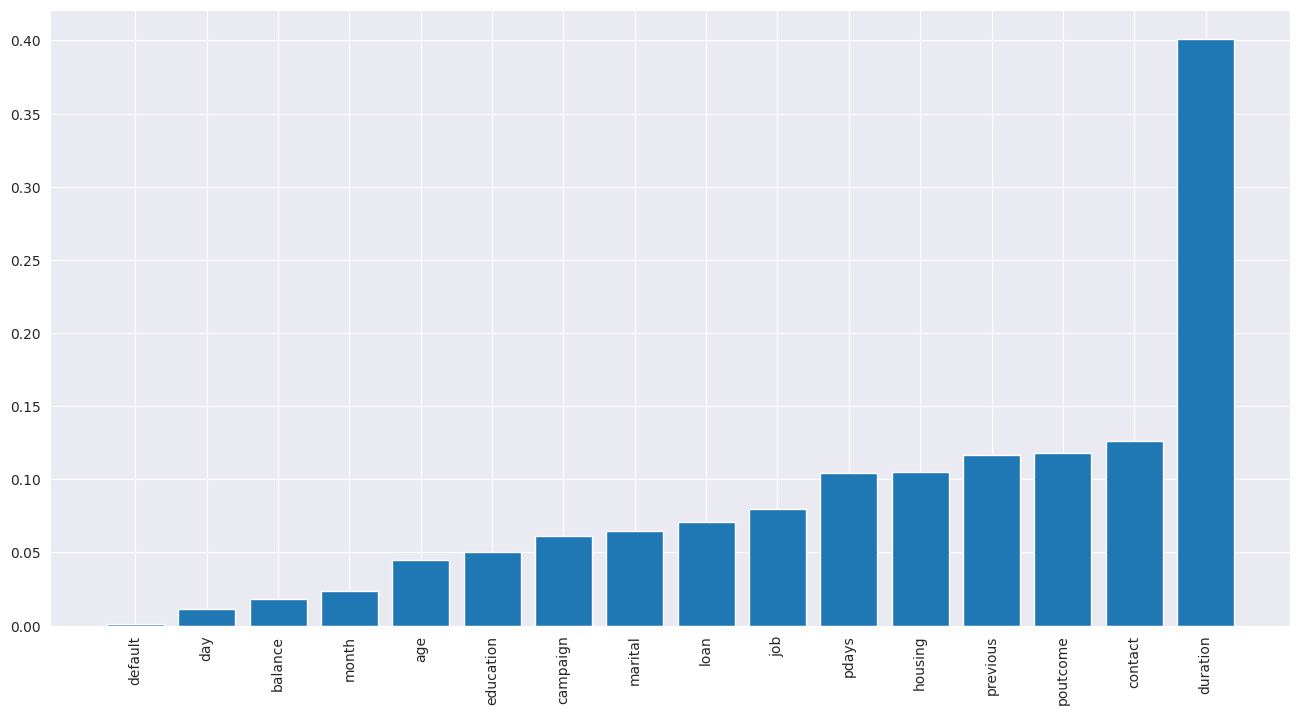

In [21]:
price_corr = dataset.corr().abs()
price_corr = price_corr.unstack().sort_values()['y']

plt.figure(figsize = (16, 8))
plt.bar(list(price_corr.keys())[:-1], list(price_corr)[:-1])
plt.xticks(rotation=90)
plt.show()

<AxesSubplot:>

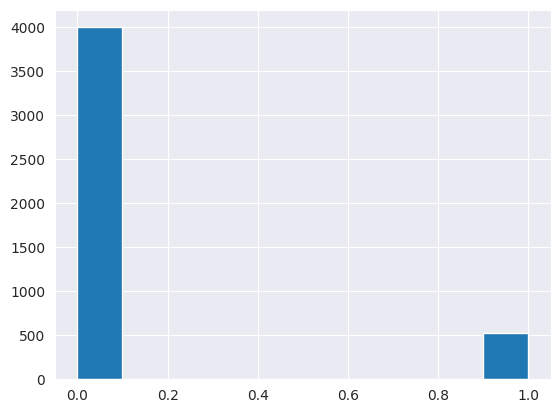

In [35]:
# балансировка классов
dataset[TARGET].hist()

In [37]:
rat = len(dataset.loc[dataset[TARGET]==0])//len(dataset.loc[dataset[TARGET]==1])
ds_1 = dataset.loc[dataset[TARGET]==1]
ds_1 = ds_1.loc[ds_1.index.repeat(rat)]
dataset_normalize = pd.concat([dataset.loc[dataset[TARGET]==0], ds_1]).sample(frac=1)

<AxesSubplot:>

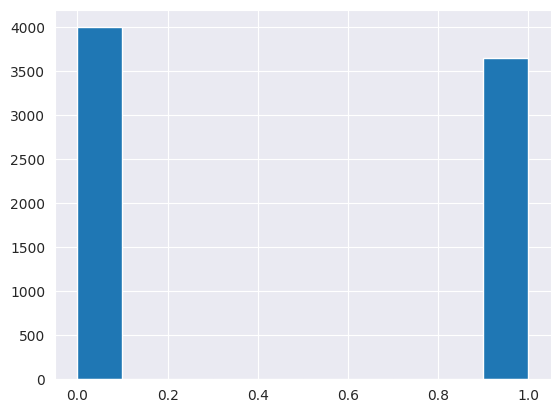

In [39]:
dataset_normalize[TARGET].hist()

In [40]:
X_train, X_test, y_train, y_test = train_test_split(dataset_normalize.drop(TARGET, axis=1), dataset_normalize[TARGET], test_size=0.2, random_state=41)

In [41]:
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

In [42]:
print(metrics.classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       1.00      0.95      0.98       793
           1       0.95      1.00      0.97       737

    accuracy                           0.98      1530
   macro avg       0.98      0.98      0.98      1530
weighted avg       0.98      0.98      0.98      1530



In [43]:
print('ROC: ', metrics.roc_auc_score(y_test, y_pred))

ROC:  0.9760403530895334


In [59]:
# shap.initjs()
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(X_train)[0]

In [63]:
features = X_train.columns

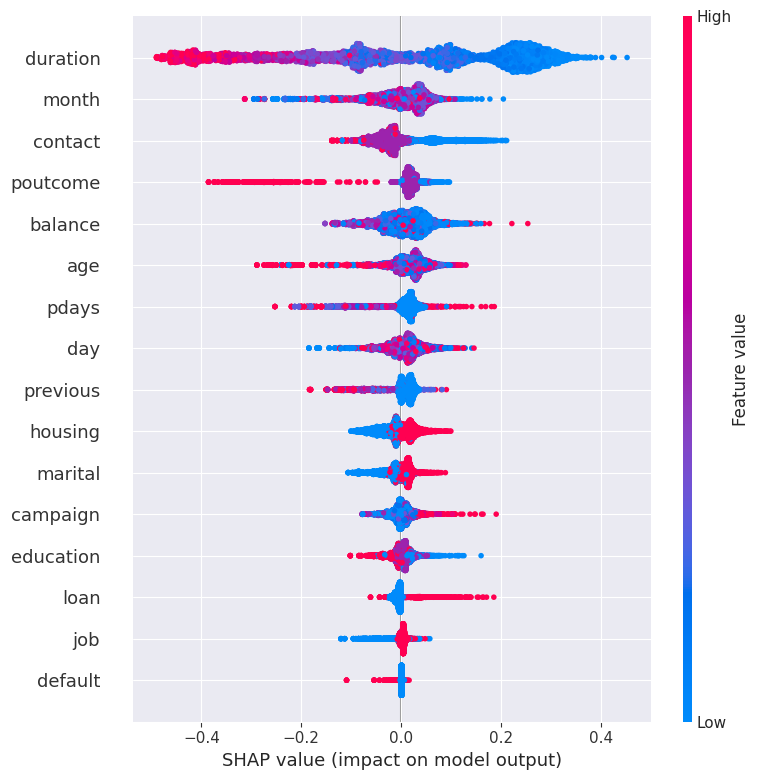

In [69]:
shap.summary_plot(shap_values, X_train, feature_names=features)

In [66]:
shap.force_plot(explainer.expected_value[0], shap_values[0,:], features=X_train.iloc[0,:],feature_names=features)

In [75]:
shap.force_plot(explainer.expected_value[0], shap_values[8,:], X_train.iloc[8,:], feature_names=features)

In [76]:
shap.force_plot(explainer.expected_value[0], shap_values[1,:], X_train.iloc[1,:], feature_names=features)

In [77]:
shap.force_plot(explainer.expected_value[0], shap_values[100,:], X_train.iloc[100,:], feature_names=features)